In [1]:
using Pkg
Pkg.activate("MNIST")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/QROT/notebooks/ex_MNIST/MNIST`


In [305]:
using Glob
using CSV
using DataFrames
using Plots
using StatsPlots
using StatsBase
using LaTeXStrings
using ColorSchemes
pal=palette(:Set1_9)

plt1s = []
plt2s = []
plt3s = []
plt4s = []

for N in [100, 250, 500]
    fnames = Glob.glob("output/mnist_results_N_$(N)_seed_*.csv")
    fnames = fnames[.!map(x -> contains(x, "_pca"), fnames)]

    df = [CSV.read(f, DataFrame) for f in fnames];
    plt=plot(; ylim = (0.5, 0.8), size = (500, 250), title = "N = $N", titlefontsize = 10)
    errorline!(df[1].eps_quad, hcat([x.nmi_quad for x in df]...), xscale = :log10, marker = :circle, label = "Bistochastic L2", legend = :outertopright, color = pal[2], groupcolor = pal[2], xlabel = L"\varepsilon", ylabel = "NMI", markerstrokewidth = 0)
    errorline!(df[1].eps_ent, hcat([x.nmi_ent for x in df]...), xscale = :log10, marker = :circle, label = "Bistochastic Ent", color = pal[1], groupcolor = pal[1], markerstrokewidth = 0)
    errorline!(df[1].eps_quad, hcat([x.nmi_quad_fat for x in df]...), xscale = :log10, marker = :circle, label = "Bistochastic L2 (fat)", color = pal[3], groupcolor = pal[3], markerstrokewidth = 0)
    errorline!(df[1].eps_ent, hcat([x.nmi_ent_fat for x in df]...), xscale = :log10, marker = :circle, label = "Bistochastic Ent (fat)", color = pal[4], groupcolor = pal[4], markerstrokewidth = 0)
    hline!([mean([maximum(x.nmi_knn) for x in df]), ], label = L"$k$-NN (best over all $k$)", color = pal[5], linestyle = :dash)
    push!(plt1s, plt)

    plt=plot(; ylim = (0.25, 0.55), size = (500, 250), title = "N = $N", titlefontsize = 10)
    errorline!(df[1].eps_quad, hcat([x.theta_quad for x in df]...), xscale = :log10, marker = :circle, label = "Bistochastic L2", legend = :outertopright, color = pal[2], groupcolor = pal[2], xlabel = L"\varepsilon", ylabel = L"\langle\theta\rangle", markerstrokewidth = 0)
    errorline!(df[1].eps_ent, hcat([x.theta_ent for x in df]...), xscale = :log10, marker = :circle, label = "Bistochastic Ent", color = pal[1], groupcolor = pal[1], markerstrokewidth = 0)
    errorline!(df[1].eps_quad, hcat([x.theta_quad_fat for x in df]...), xscale = :log10, marker = :circle, label = "Bistochastic L2 (fat)", color = pal[3], groupcolor = pal[3], markerstrokewidth = 0)
    errorline!(df[1].eps_ent, hcat([x.theta_ent_fat for x in df]...), xscale = :log10, marker = :circle, label = "Bistochastic Ent (fat)", color = pal[4], groupcolor = pal[4], markerstrokewidth = 0)
    hline!([mean([minimum(x.theta_knn) for x in df]), ], label = L"$k$-NN (best over all $k$)", color = pal[5], linestyle = :dash)
    push!(plt2s, plt)

    fnames = Glob.glob("output/mnist_results_N_$(N)_seed_*_pca.csv")
    df = [CSV.read(f, DataFrame) for f in fnames];
    plt=plot(; ylim = (0.4, 0.8), size = (500, 250))
    errorline!(df[1].d, hcat([x.nmi_quad for x in df]...), marker = :circle, label = "Bistochastic L2", legend = :outertopright, color = pal[2], groupcolor = pal[2], xlabel = "PCA components", ylabel = "NMI", markerstrokewidth = 0)
    errorline!(df[1].d, hcat([x.nmi_ent for x in df]...), marker = :circle, label = "Bistochastic Ent", color = pal[1], groupcolor = pal[1], markerstrokewidth = 0)
    errorline!(df[1].d, hcat([x.nmi_knn for x in df]...), marker = :circle, label = L"$k$-NN", color = pal[5], groupcolor = pal[5], markerstrokewidth = 0)
    push!(plt3s, plt)

    plt=plot(; ylim = (0.0, 0.8), size = (500, 250))
    errorline!(df[1].d, hcat([x.theta_quad for x in df]...), marker = :circle, label = "Bistochastic L2", legend = :outertopright, color = pal[2], groupcolor = pal[2], xlabel = "PCA components", ylabel = L"\langle \theta \rangle", markerstrokewidth = 0)
    errorline!(df[1].d, hcat([x.theta_ent for x in df]...), marker = :circle, label = "Bistochastic Ent", color = pal[1], groupcolor = pal[1], markerstrokewidth = 0)
    errorline!(df[1].d, hcat([x.theta_knn for x in df]...), marker = :circle, label = L"$k$-NN", color = pal[5], groupcolor = pal[5], markerstrokewidth = 0)
    push!(plt4s, plt)
end

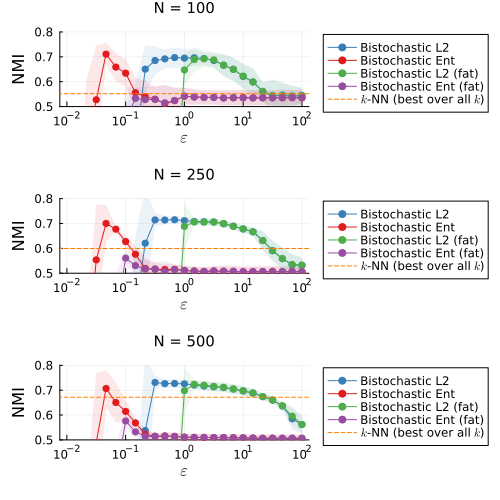

In [306]:
plt=plot(plt1s...; layout = (3, 1), size = (500, 500))
savefig(plt, "../../figures/MNIST_NMI_vs_eps.svg")
plt

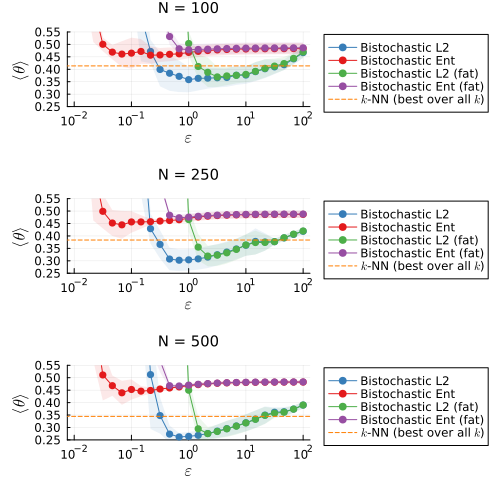

In [307]:
plt=plot(plt2s...; layout = (3, 1), size = (500, 500))
savefig(plt, "../../figures/MNIST_theta_vs_eps.svg")
plt

In [308]:
using NPZ
using Graphs
using SimpleWeightedGraphs
using OptimalTransport
using LinearAlgebra
include("../../src/util.jl")

N = 250
X = npzread("output/X_N_$(N)_seed_1.npy")
X_pca = npzread("output/X_pca_N_$(N)_seed_1.npy")'
y = npzread("output/y_N_$(N)_seed_1.npy")
clust_ent = npzread("output/clust_ent_N_$(N)_seed_1.npy")
clust_quad = npzread("output/clust_quad_N_$(N)_seed_1.npy")

eps_quad = 1.0
K_quad_ = kernel_ot_quad(X, eps_quad);

In [309]:
using LogExpFunctions
perplexity(K) = map(x -> exp(sum(-xlogx.(x))), eachrow(K))
perp_quad = mean(perplexity(K_quad_))

13.030161762068946

In [310]:
# simple bisection search to match perplexity
eps_ent_l, eps_ent_r = 0.0, 1.0
K_ent_ = similar(K_quad_)
for _ = 1:10
    eps_ent = (eps_ent_l + eps_ent_r)/2
    K_ent_ .= kernel_ot_ent(X, eps_ent)
    perp_ent = mean(perplexity(K_ent_))
    if perp_ent > perp_quad 
        eps_ent_r = eps_ent
    else
        eps_ent_l = eps_ent
    end
    @info "perp_ent = $(perp_ent), eps_ent = $(eps_ent)"
end

[ Info: perp_ent = 888.240264047899, eps_ent = 0.5
[ Info: perp_ent = 615.8386604364595, eps_ent = 0.25
[ Info: perp_ent = 215.46656074033558, eps_ent = 0.125
[ Info: perp_ent = 41.91168029298035, eps_ent = 0.0625
[ Info: perp_ent = 10.575926534346841, eps_ent = 0.03125
[ Info: perp_ent = 22.456025456350513, eps_ent = 0.046875
[ Info: perp_ent = 15.737541227814464, eps_ent = 0.0390625
[ Info: perp_ent = 12.980467308634259, eps_ent = 0.03515625
[ Info: perp_ent = 14.312890053071465, eps_ent = 0.037109375
[ Info: perp_ent = 13.635424352252446, eps_ent = 0.0361328125


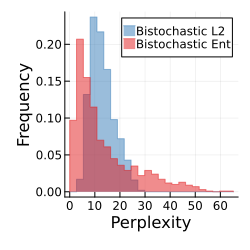

In [311]:
plt=stephist(perplexity(K_quad_), weights = ones(size(K_quad_, 1))/size(K_quad_, 1), alpha = 0.5, bins = range(0, 5*perp_quad, 25), label = "Bistochastic L2", fill = true, xlabel = "Perplexity", ylabel = "Frequency", size = (250, 250), color = pal[2])
stephist!(perplexity(K_ent_), weights = ones(size(K_ent_, 1))/size(K_ent_, 1), alpha = 0.5, bins = range(0, 5*perp_quad, 25), label = "Bistochastic Ent", fill = true, color = pal[1])
savefig(plt, "../../figures/MNIST_perplexity_freq.svg")
plt

In [312]:
eigs_quad = eigen(I - Hermitian(K_quad_));
eigs_ent = eigen(I - Hermitian(K_ent_));

In [ ]:
plt1=plot([scatter(X_pca[:, 1], X_pca[:, 2], marker_z = eigs_ent.vectors[:, i], colormap = :RdBu, clim = (-0.075, 0.075), alpha = 0.5, title = latexstring("\$\\mathbf{v}_{$(i)}\$")) for i = 2:5]...; 
    layout = (1, 4), colorbar = false, markerstrokewidth = 0.5, legend = nothing)
plt2=plot([scatter(X_pca[:, 1], X_pca[:, 2], marker_z = eigs_quad.vectors[:, i], colormap = :RdBu, clim = (-0.075, 0.075), alpha = 0.5, title = latexstring("\$\\mathbf{v}_{$(i)}\$")) for i = 2:5]...; 
    layout = (1, 4), colorbar = false, markerstrokewidth = 0.5, legend = nothing)
plt=plot(plt2, plt1; layout = (2, 1), size = (750, 375), xlabel = "PCA1", ylabel = "PCA2", xlabelfontsize = 8, ylabelfontsize = 8)
savefig(plt, "../../figures/MNIST_eigenvectors_scatter.svg")
plt

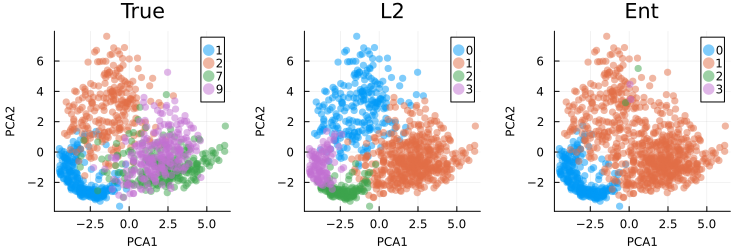

In [339]:
plt=plot(scatter(X_pca[:, 1], X_pca[:, 2], groups = y, alpha = 0.5, title = "True", xlabel = "PCA1", ylabel = "PCA2", ylabelfontsize = 8, xlabelfontsize = 8),
    scatter(X_pca[:, 1], X_pca[:, 2], groups = clust_quad, alpha = 0.5, title = "L2", xlabel = "PCA1", ylabel = "PCA2", ylabelfontsize = 8, xlabelfontsize = 8),
    scatter(X_pca[:, 1], X_pca[:, 2], groups = clust_ent, alpha = 0.5, title = "Ent", xlabel = "PCA1", ylabel = "PCA2", ylabelfontsize = 8, xlabelfontsize = 8),
    layout = (1, 3), markerstrokewidth = 0, size = (750, 250), margin = 3*Plots.mm)
savefig(plt, "../../figures/MNIST_clusters.svg")
plt

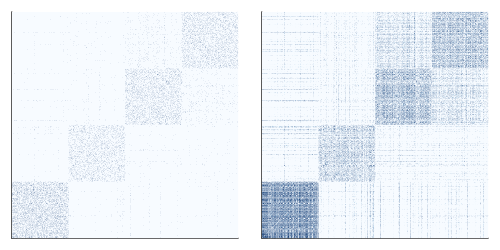

In [320]:
plt=plot(heatmap(K_quad_, clim = (0, 1e-4), color = :Blues),
    heatmap(K_ent_, clim = (0, 1e-4), color = :Blues), colorbar = false, size = (500, 250), xaxis = nothing, yaxis = nothing)
savefig(plt, "../../figures/MNIST_heatmap.svg")
plt

In [321]:
function get_diffusion_embeddings(eigs, τ)
    (abs.(1 .- eigs.values).^τ .* eigs.vectors')'
end

get_diffusion_embeddings (generic function with 1 method)

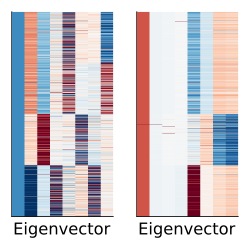

In [576]:
U_quad = get_diffusion_embeddings(eigs_quad, 1.)
U_ent = get_diffusion_embeddings(eigs_ent, 1.)
plt=plot(heatmap(U_quad[:, 1:8], cmap = :RdBu, titlefontsize = 10), 
    heatmap(U_ent[:, 1:8], cmap = :RdBu, titlefontsize = 10), clim = (-0.05, 0.05), colorbar = nothing, size = (250, 250), xlabel = "Eigenvector", axis = nothing)
savefig(plt, "../../figures/MNIST_eigenvectors.svg")
plt

In [329]:
using PyCall
sk_mf = pyimport_conda("sklearn.manifold", "sklearn")
mds_op = sk_mf.MDS(random_state = 0, n_components = 2)
y_mds_quad = mds_op.fit_transform(U_quad[:, 1:8])';
mds_op = sk_mf.MDS(random_state = 0, n_components = 2)
y_mds_ent = mds_op.fit_transform(U_ent[:, 1:8])';

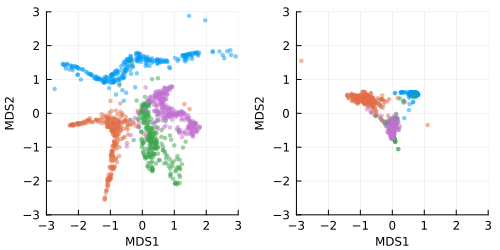

In [543]:
z_mds_quad = StatsBase.transform(fit(ZScoreTransform, y_mds_quad), y_mds_quad)
z_mds_ent = StatsBase.transform(fit(ZScoreTransform, y_mds_ent), y_mds_ent)

plt=plot(scatter(z_mds_quad[1, :], z_mds_quad[2, :], groups = y, markerstrokewidth = 0, alpha = 0.5),
     scatter(z_mds_ent[1, :], z_mds_ent[2, :], groups = y, markerstrokewidth = 0, alpha = 0.5), xlim = (-3, 3), ylim = (-3, 3), markersize = 2.5, 
     xlabel = "MDS1", ylabel = "MDS2", size = (500, 250), legend = nothing, 
    titlefontsize = 12, xlabelfontsize = 8, ylabelfontsize = 8)
savefig(plt, "../../figures/MNIST_diffusion_mds.svg")
plt

In [642]:
digit = 1
mds_op = sk_mf.MDS(random_state = 0, n_components = 2)
y_mds_quad_digit = mds_op.fit_transform(U_quad[y .== digit, 1:8])';
mds_op = sk_mf.MDS(random_state = 0, n_components = 2)
y_mds_ent_digit = mds_op.fit_transform(U_ent[y .== digit, 1:8])';
z_mds_quad_digit = StatsBase.transform(fit(ZScoreTransform, y_mds_quad_digit), y_mds_quad_digit)
z_mds_ent_digit = StatsBase.transform(fit(ZScoreTransform, y_mds_ent_digit), y_mds_ent_digit);

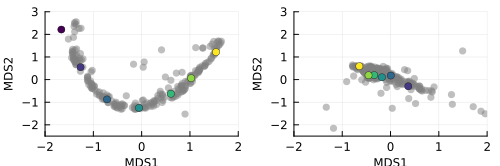

In [643]:
idxs = sortperm(y_mds_quad_digit[1, :])[1:40:end]
_pal=palette(:viridis, length(idxs))
plt1 = scatter(z_mds_quad_digit[1, :], z_mds_quad_digit[2, :], color = :grey, markerstrokewidth = 0, alpha = 0.5, legend = nothing, ylim = (-2.5, 3), xlim = (-2, 2))
for (j, i) in enumerate(idxs)
    # annotate!(plt1, z_mds_quad_digit[1, i] + 0.1, z_mds_quad_digit[2, i] + 0.2, "$j")
    scatter!(plt1, [z_mds_quad_digit[1, i], ], [z_mds_quad_digit[2, i], ], color = _pal[j])
end
plt2 = scatter(z_mds_ent_digit[1, :], z_mds_ent_digit[2, :], color = :grey, markerstrokewidth = 0, alpha = 0.5, legend = nothing, ylim = (-2.5, 3), xlim = (-2, 2))
for (j, i) in enumerate(idxs)
    # annotate!(plt2, z_mds_ent_digit[1, i] + 0.1, z_mds_ent_digit[2, i] + 0.2, "$j")
    scatter!(plt2, [z_mds_ent_digit[1, i], ], [z_mds_ent_digit[2, i], ], color = _pal[j])
end
plt=plot(plt1, plt2, 
    xlabel = "MDS1", ylabel = "MDS2", size = (500, 250*2/3), legend = nothing, 
    titlefontsize = 12, xlabelfontsize = 8, ylabelfontsize = 8)
savefig(plt, "../../figures/MNIST_diffusion_mds_digit_$(digit).svg")
plt

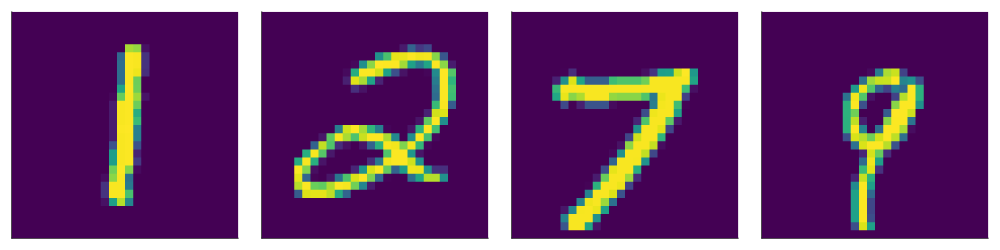

In [644]:
plt=plot([heatmap(reshape(X[:, findall(y .== digit)[3]], 28, 28)[:, end:-1:1]', axis = nothing, aspect_ratio = :equal, colorbar = nothing, colormap = :viridis) for digit in [1, 2, 7, 9]]..., layout = (1, 4), size = (1000, 250))
savefig(plt, "../../figures/MNIST_ex.svg")
plt

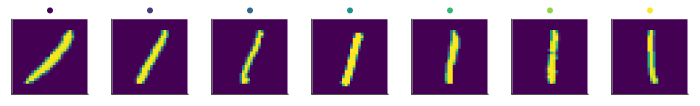

In [645]:
plt=plot([heatmap(x[:, end:-1:1]', colorbar = nothing, aspect_ratio = :equal, axis = nothing, colormap = :viridis, title = "•", titlefontcolor = _pal[i]) 
        for (i, x) in enumerate([reshape(X[:, y .== digit][:, i], 28, 28) for i in idxs])]..., layout = (1, 7), size = (700, 106))
savefig(plt, "../../figures/MNIST_digits_$(digit).svg")
plt

In [551]:
size(X)

(784, 1000)

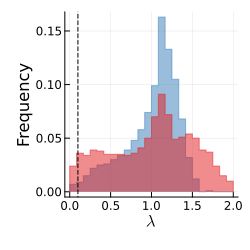

In [722]:
using LaTeXStrings
t = 0.1
plt=stephist(eigs_quad.values, weights = ones(size(K_quad_, 1))/size(K_quad_, 1), bins = range(0, 2, 25), fill = true, color = pal[2], alpha = 0.5, size = (250, 250), label = "Bistochastic L2")
stephist!(eigs_ent.values, weights = ones(size(K_ent_, 1))/size(K_ent_, 1), bins = range(0, 2, 25), fill = true, color = pal[1], alpha = 0.5, label = "Bistochastic Ent", legend = nothing, xlabel = L"$\lambda$", ylabel = "Frequency")
vline!([t, ], linestyle = :dash, color = :black)
savefig(plt, "../../figures/MNIST_eigenvalues.svg")
plt

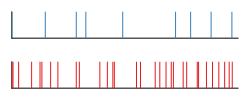

In [723]:
plt1=vline(eigs_quad.values, xlim = (0, t), axis = nothing, color = pal[2], alpha = 1, legend = nothing, linewidth = 1)
plt2=vline(eigs_ent.values, xlim = (0, t), axis = nothing, color = pal[1], alpha = 1, legend = nothing, linewidth = 1)
plt=plot(plt1, plt2; layout = (2, 1), size = (250, 100))
savefig(plt, "../../figures/MNIST_eigenvalues_zoom.svg")
plt